In [1]:
import numpy as np
import matplotlib as mpl
from skimage.io import imread, imshow
from scipy.fft import fftshift, ifftshift, fft2, ifft2, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import string

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reconstruction functions

In [3]:
M = 20  # lens magnification
f = 400  # lens focal length [um]
wave_length = 0.6328  # wave length im [um]
pixel_size = 3.5

In [4]:
def angular_spectrum_reconstruct(d, holo, wave_length, M, f,pixel_size):
    dx = pixel_size/M
    dy = pixel_size/M
    Nx = np.shape(holo)[0]
    Ny = np.shape(holo)[1]
    Dx = (Nx/2)*dx
    Dy = (Ny/2)*dy
    x = np.arange(-Dx,Dx, dx)
    y = np.arange(-Dy,Dy, dy)
    X,Y = np.meshgrid(x, y)

    dnux = 1/Nx/dx
    dnuy = 1/Ny/dy
    nux = np.arange(-0.5/dx,0.5/dx, dnux)
    nuy = np.arange(-0.5/dy,0.5/dy, dnuy)
    [Nux,Nuy] = np.meshgrid(nux,nuy)

    H = np.exp(-1*2*np.pi * d * np.sqrt(1/(wave_length**2) - Nux**2 - Nuy**2)*1j)
    H[1/(wave_length**2)-Nux**2-Nuy**2 < 0] = 0
    H=np.transpose(H)

    fft_amp = fftshift(fft2(ifftshift(holo)))
    Psi = fftshift(ifft2(ifftshift (fft_amp*H)))
    print(d)
    return Psi

In [5]:
def fresnel_reconstruction(holo, wavelength, distance, pixel_size, M, f):

    # Calculate the wave number
    k = 2 * np.pi / wavelength

    # Calculate the effective pixel size at the hologram plane
    eff_pixel_size = pixel_size / M

    # Create the spatial frequency grid
    u, v = fftfreq(holo.shape[0], eff_pixel_size), fftfreq(holo.shape[1], eff_pixel_size)
    uu, vv = np.meshgrid(u, v, indexing='ij')
    spatial_freq_sq = uu**2 + vv**2

    # Calculate the Fourier transform of the hologram and shift it to center
    holo_ft = fftshift(fft2(ifftshift(holo)))

    # Calculate the phase factor
    #phase_factor = np.exp(1j * k * distance) * np.exp(-1j * k * distance * spatial_freq_sq * wavelength * f)
    G = (1j / wave_length) * np.exp((-1j * k / (2 * distance)) * spatial_freq_sq)

    # Perform the Fresnel reconstruction
    recon_wavefront = fftshift(ifft2(ifftshift(holo_ft * G)))

    return recon_wavefront


# Amplitude reconstruction

(2048, 2048)
0.048744565699583 1.0


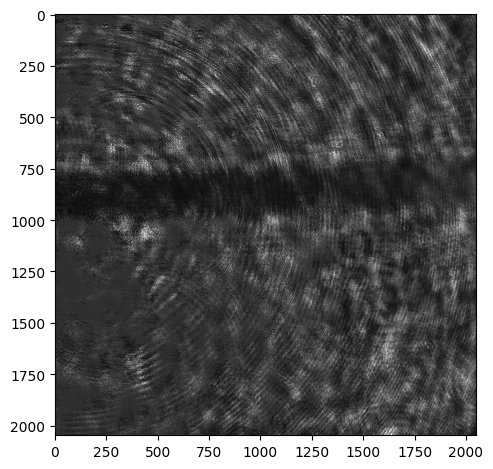

In [22]:
im_orig = imread('/content/drive/MyDrive/Kai physics/3rd year/Lab B/Holography/images/day3/NEW/200.bmp')
im_orig = im_orig[:2048,:2048] / 256
im_bg = imread('/content/drive/MyDrive/Kai physics/3rd year/Lab B/Holography/images/day3/NEW/bg.bmp')
im_bg = im_bg[:2048,:2048] / 256

holo = (im_orig/im_bg) # substruct background and normalize pixels
holo = holo / holo.max()
height, width = np.shape(holo)
holo = holo[:2048,:2048] # crop to shape power of 2 for faster proccessing

print(np.shape(holo))
print(holo.min(), holo.max())
imshow(holo)

Text(0, 0.5, 'Pixels [3.5 $\\mu$m]')

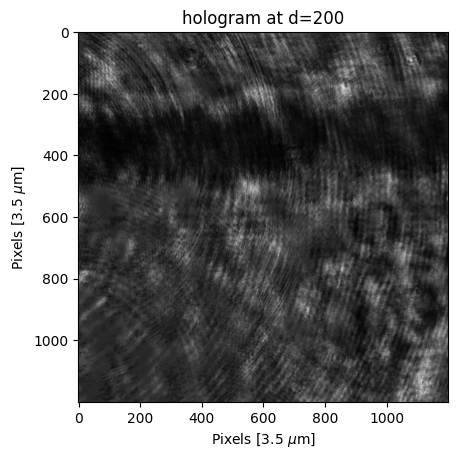

In [25]:
h_b, w_b = [(500,1700),(500, 1700)]
plt.imshow(holo[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap='gray')
# plt.imshow(holo, cmap='gray')
plt.title(r'hologram at d=200')
plt.xlabel(r'Pixels [3.5 $\mu$m]')
plt.ylabel(r'Pixels [3.5 $\mu$m]')

In [26]:
depths = np.arange(100, 350 ,10)
print(f"depths = {depths}")
recon_layers = np.array([angular_spectrum_reconstruct(d, holo, wave_length, M, f,pixel_size) for d in depths])
#recon_layers = np.array([fresnel_reconstruction(holo, wave_length, d, pixel_size, M, f) for d in depths])

depths = [100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270
 280 290 300 310 320 330 340]


<ipython-input-4-1cc6fb6f4db1>:18: RuntimeWarning: invalid value encountered in sqrt
  H = np.exp(-1*2*np.pi * d * np.sqrt(1/(wave_length**2) - Nux**2 - Nuy**2)*1j)


100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340


In [27]:
print(f"shape {recon_layers.shape}\n")
print(f"magnitude:")
abs_layers = np.absolute(recon_layers)
abs_layers = np.asarray([layer / layer.max() for layer in abs_layers])
print(abs_layers.min(), abs_layers.max())
print(abs_layers.shape)

# print(f"\nphase:")
# phase_layers = np.arctan((np.imag(recon_layers)/np.real(recon_layers)) % 2*np.pi)
# print(phase_layers.min(), phase_layers.max())
# print(phase_layers.shape)

shape (25, 2048, 2048)

magnitude:
0.00018761857110371593 1.0
(25, 2048, 2048)


In [28]:
%matplotlib inline
from ipywidgets import interact, FloatSlider, IntSlider

def reconstruction_slider(d):
    fig, ax = plt.subplots(figsize=(10,7))

    # im1 = ax.imshow(abs_layers[d, h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap='gray')
    im = ax.imshow(abs_layers[d], cmap='gray')
    ax.set_title(f'reconstruction from d={depths[d]} $[\mu m]$')
    ax.set_xlabel(r'Pixels [3.5 $\mu$m]')
    ax.set_ylabel(r'Pixels [3.5 $\mu$m]')
    # fig.colorbar(im)
    plt.show()

interact(reconstruction_slider,
         d=IntSlider(min=0, max=np.shape(recon_layers)[0]-1, step=1, value=0, readout_format='.2f'));


interactive(children=(IntSlider(value=0, description='d', max=24, readout_format='.2f'), Output()), _dom_class…

# distance measurment

In [ ]:
x_holo = np.array([242,299, 354, 407, 461, 513])
distances = np.array([316-242,375-299, 422-354, 467-407, 523-461, 571-513])
textstr = '\n'.join((
    r'$\mu=%.2f$' % (distances.mean(), ),
    r'$\sigma=%.2f$' % (distances.std(), )))

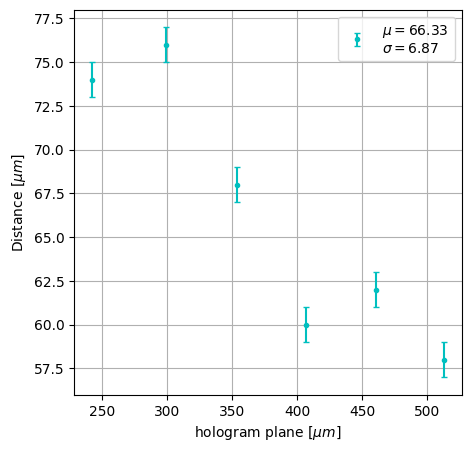

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

ax.errorbar(x=x_holo, y=distances, yerr = 1, fmt='.',capsize=2, color='c', label=textstr)
ax.set_ylabel('Distance [$\mu m$]')
ax.set_xlabel('hologram plane [$\mu m$]')
plt.grid()
plt.legend()

# Animation

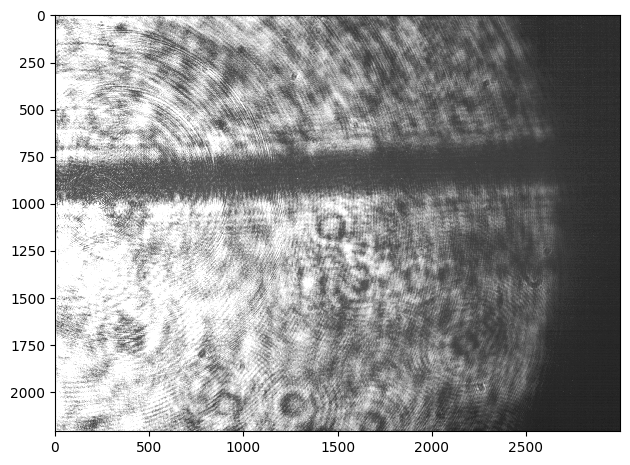

In [ ]:
im_orig = imread('/content/drive/MyDrive/Kai physics/3rd year/Lab B/Holography/images/day3/NEW/200.bmp')
im_bg = imread('/content/drive/MyDrive/Kai physics/3rd year/Lab B/Holography/images/day3/NEW/bg.bmp')
imshow(im_orig)

(2048, 2048)
49 255


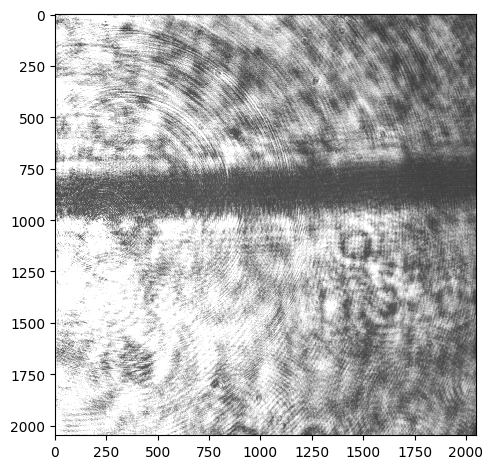

In [ ]:
holo = (im_orig) # substruct background and normalize pixels
# holo = im_orig / 256
# holo =  holo / holo.max()
height, width = np.shape(holo)
holo = holo[:2048,:2048] # crop to shape power of 2 for faster proccessing

print(np.shape(holo))
print(holo.min(), holo.max())
imshow(holo)

Text(0, 0.5, 'Pixels [3.5 $\\mu$m]')

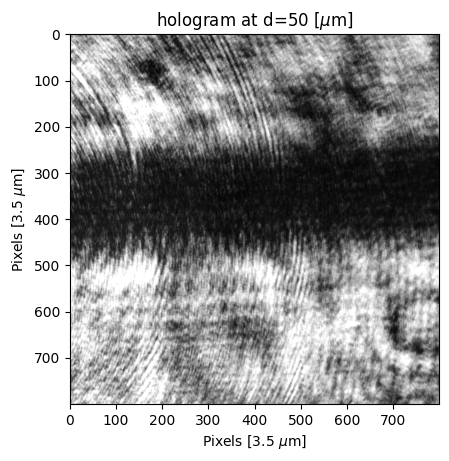

In [ ]:
h_b, w_b = [(500, 1300),(700, 1500)]
plt.imshow(holo[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap='gray')
# plt.imshow(holo, cmap='gray')
plt.title(r'hologram at d=50 [$\mu$m]')
plt.xlabel(r'Pixels [3.5 $\mu$m]')
plt.ylabel(r'Pixels [3.5 $\mu$m]')

In [ ]:
depths = np.arange(1, 145 ,2)
print(f"depths = {depths}")
recon_layers = np.array([angular_spectrum_reconstruct(d, holo, wave_length, M, f,pixel_size) for d in depths])
#recon_layers = np.array([fresnel_reconstruction(holo, wave_length, d, pixel_size, M, f) for d in depths])

In [ ]:
print(f"shape {recon_layers.shape}\n")
print(f"magnitude:")
abs_layers = np.absolute(recon_layers)
# abs_layers = np.asarray([layer / layer.max() for layer in abs_layers])
print(abs_layers.min(), abs_layers.max())
print(abs_layers.shape)

# print(f"\nphase:")
# phase_layers = np.arctan((np.imag(recon_layers)/np.real(recon_layers)) % 2*np.pi)
# print(phase_layers.min(), phase_layers.max())
# print(phase_layers.shape)

shape (72, 2048, 2048)

magnitude:
0.44931031614221006 439.4644350904939
(72, 2048, 2048)


In [ ]:

fig, ax = plt.subplots()
title = ax.text(0.5,0.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                transform=ax.transAxes, ha="center")
ims = []
for d in range(len(depths)):
  title = ax.text(0.5,0.85, f'reconstruction for d={depths[d]} $[\mu m]$',
                  bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                  transform=ax.transAxes, ha="center")
  ax.set_xlabel(r'Pixels')
  ax.set_ylabel(r'Pixels')
  im = ax.imshow(abs_layers[d, h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap='gray')
  ims.append([im, title])

ani = animation.ArtistAnimation(fig, ims, interval=120, blit=False, repeat_delay=1000)
HTML(ani.to_jshtml())

In [ ]:
writer = animation.PillowWriter(fps=15,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('reconstruction2.gif', writer=writer)

# Phase retrieval attempt

(2048, 2048)
0.17647058823529413 1.0


Text(79.31861111111108, 0.5, 'Pixels [3.5 $\\mu$m]')

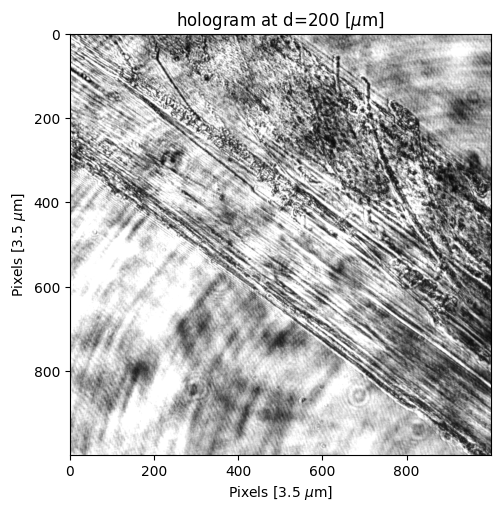

In [6]:
im_orig = imread('/content/drive/MyDrive/Kai physics/3rd year/Lab B/Holography/images/day2/scratch2.bmp')
im_bg = imread('/content/drive/MyDrive/Kai physics/3rd year/Lab B/Holography/images/day2/bg.bmp')
imshow(im_orig)

holo = (im_orig/im_bg) # substruct background and normalize pixels
holo = im_orig / 256
holo = holo / holo.max()
height, width = np.shape(holo)
holo = holo[:2048,:2048] # crop to shape power of 2 for faster proccessing

print(np.shape(holo))
print(holo.min(), holo.max())
imshow(holo)

h_b, w_b = [(250, 1250),(500, 1500)]
plt.imshow(holo[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap='gray')
# plt.imshow(holo, cmap='gray')
plt.title(r'hologram at d=200 [$\mu$m]')
plt.xlabel(r'Pixels [3.5 $\mu$m]')
plt.ylabel(r'Pixels [3.5 $\mu$m]')

In [7]:
depths = np.arange(0.1, 1 ,0.1)
print(f"depths = {depths}")
recon_layers = np.array([angular_spectrum_reconstruct(d, holo, wave_length, M, f,pixel_size) for d in depths])
#recon_layers = np.array([fresnel_reconstruction(holo, wave_length, d, pixel_size, M, f) for d in depths])

depths = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


<ipython-input-4-1cc6fb6f4db1>:18: RuntimeWarning: invalid value encountered in sqrt
  H = np.exp(-1*2*np.pi * d * np.sqrt(1/(wave_length**2) - Nux**2 - Nuy**2)*1j)


0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9


In [10]:
print(f"shape {recon_layers.shape}\n")
print(f"magnitude:")
abs_layers = np.absolute(recon_layers)
abs_layers = np.asarray([layer / layer.max() for layer in abs_layers])
print(abs_layers.min(), abs_layers.max())
print(abs_layers.shape)

from skimage.restoration import unwrap_phase

print(f"real: {np.real(recon_layers.min())} to {np.real(recon_layers.max())}")
print(f"imaginary: {np.imag(recon_layers.min())} to {np.imag(recon_layers.max())}")

print(f"\nphase:")
phase_layers = np.arctan((np.imag(recon_layers+1)/np.real(recon_layers+1))) % 2*np.pi
# phase_layers = unwrap_phase(phase_layers)
print(phase_layers.min(), phase_layers.max())
print(phase_layers.shape)

shape (9, 2048, 2048)

magnitude:
0.0813071744837426 1.0
(9, 2048, 2048)
real: -1.1040630104861364 to 1.18242918110999
imaginary: -0.17798161631558862 to 0.48323024635909073

phase:
6.152766629553762e-08 6.283182789898272
(9, 2048, 2048)


In [12]:
%matplotlib inline
from ipywidgets import interact, FloatSlider, IntSlider

def reconstruction_slider(d):
    fig = plt.figure(figsize=(10,10))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(abs_layers[d, h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap='gray')

    ax2 = fig.add_subplot(1,2,2, projection='3d')
    height, width = abs_layers[0,  h_b[0]:h_b[1], w_b[0]:w_b[1]].shape
    X, Y = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    ax2.plot_surface(X, Y, phase_layers[d, h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap='inferno')
    ax2.set_zlim(0,2*np.pi)

    ax1.set_title(f'reconstruction from d={depths[d]:.2f} $[\mu m]$')
    ax1.set_xlabel(r'Pixels [3.5 $\mu$m]')
    ax1.set_ylabel(r'Pixels [3.5 $\mu$m]')
    plt.show()

interact(reconstruction_slider,
         d=IntSlider(min=0, max=np.shape(recon_layers)[0]-1, step=1, value=0, readout_format='.2f'));

interactive(children=(IntSlider(value=0, description='d', max=8, readout_format='.2f'), Output()), _dom_classe…

# Figures

## reconstruction proccess

<ipython-input-77-03163efdcd61>:36: RuntimeWarning: invalid value encountered in sqrt
  H = np.exp(-1*2*np.pi * d * np.sqrt(1/(wave_length**2) - Nux**2 - Nuy**2)*1j)
<ipython-input-77-03163efdcd61>:43: RuntimeWarning: divide by zero encountered in log
  ax[1][1].imshow(np.log(np.abs(arg))[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap='inferno')


Text(0.02, 0.5, 'Pixels')

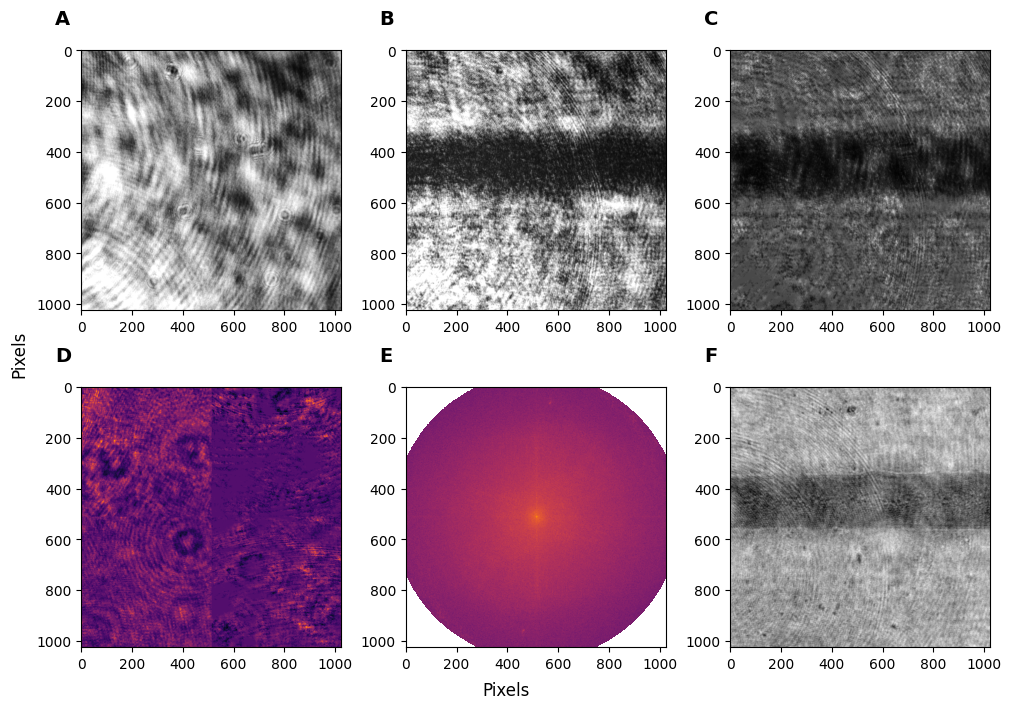

In [77]:

fig, ax = plt.subplots(2,3,figsize=(10,7),layout='constrained')
cmap = 'gray'
h_b, w_b = [(511,2048-512),(511,2048-512)]

im_orig = imread('/content/drive/MyDrive/Kai physics/3rd year/Lab B/Holography/images/day3/200.bmp')
im_orig = im_orig[:2048,:2048] / 256
im_bg = imread('/content/drive/MyDrive/Kai physics/3rd year/Lab B/Holography/images/day3/bg200.bmp')
im_bg = im_bg[:2048,:2048] / 256
ax[0][0].imshow(im_bg[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap=cmap)
ax[0][1].imshow(im_orig[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap=cmap)


holo = (im_orig/im_bg) # substruct background and normalize pixels
holo = holo / holo.max()
height, width = np.shape(holo)
holo = holo[:2048,:2048] # crop to shape power of 2 for faster proccessing
ax[0][2].imshow(holo[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap=cmap)

dx = pixel_size/M
dy = pixel_size/M
Nx = np.shape(holo)[0]
Ny = np.shape(holo)[1]
Dx = (Nx/2)*dx
Dy = (Ny/2)*dy
x = np.arange(-Dx,Dx, dx)
y = np.arange(-Dy,Dy, dy)
X,Y = np.meshgrid(x, y)

dnux = 1/Nx/dx
dnuy = 1/Ny/dy
nux = np.arange(-0.5/dx,0.5/dx, dnux)
nuy = np.arange(-0.5/dy,0.5/dy, dnuy)
[Nux,Nuy] = np.meshgrid(nux,nuy)

d = 270
H = np.exp(-1*2*np.pi * d * np.sqrt(1/(wave_length**2) - Nux**2 - Nuy**2)*1j)
H[(1/(wave_length**2)) -Nux**2 -Nuy**2 < 0] = 0
H=np.transpose(H)

fft_amp = fftshift(fft2(ifftshift(holo)))
ax[1][0].imshow(ifftshift(holo)[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap='inferno')
arg = fft_amp*H
ax[1][1].imshow(np.log(np.abs(arg))[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap='inferno')
psi = fftshift(ifft2(ifftshift (arg)))

psi_abs = np.absolute(psi)
psi_abs = psi_abs / psi_abs.max()
ax[1][2].imshow(psi_abs[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap=cmap)

for n, axes in enumerate(ax.flat):
    axes.text(-0.1, 1.1, string.ascii_uppercase[n], transform=axes.transAxes, size=14, weight='bold')

fig.supxlabel('Pixels')
fig.supylabel('Pixels')

## different depths for hair

<ipython-input-4-1cc6fb6f4db1>:18: RuntimeWarning: invalid value encountered in sqrt
  H = np.exp(-1*2*np.pi * d * np.sqrt(1/(wave_length**2) - Nux**2 - Nuy**2)*1j)


246
307


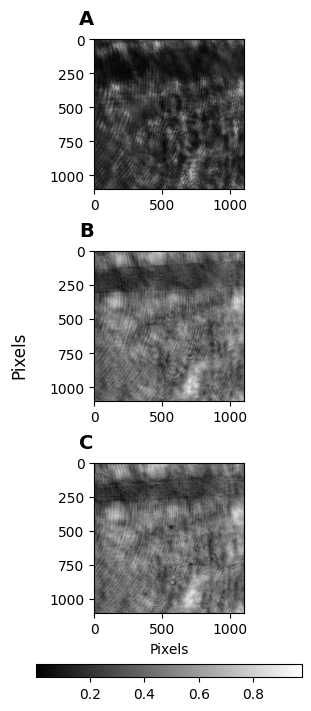

In [54]:
fig, ax = plt.subplots(3, 1, figsize=(3,7), layout='constrained')
cmap = 'gray'
h_b, w_b = [(650,1750),(900,2000)]

im_orig = imread('/content/drive/MyDrive/Kai physics/3rd year/Lab B/Holography/images/day3/NEW/200.bmp')
im_orig = im_orig[:2048,:2048] / 256
im_bg = imread('/content/drive/MyDrive/Kai physics/3rd year/Lab B/Holography/images/day3/NEW/bg.bmp')
im_bg = im_bg[:2048,:2048] / 256

holo = (im_orig/im_bg) # substruct background and normalize pixels
holo = holo / holo.max()
height, width = np.shape(holo)
holo = holo[:2048,:2048] # crop to shape power of 2 for faster proccessing

ax[0].imshow(holo[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap=cmap, label='hologram')
ax[0].set_label('hologram')

recon_246 = angular_spectrum_reconstruct(246, holo, wave_length, M, f,pixel_size)
recon_308 = angular_spectrum_reconstruct(307, holo, wave_length, M, f,pixel_size)
abs_246 = np.absolute(recon_246)
abs_246 = abs_246 / abs_246.max()
abs_308 = np.absolute(recon_308)
abs_308 = abs_308 / abs_308.max()

ax[1].imshow(abs_246[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap=cmap, label='z=246 [\mu m]')
ax[1].set_label('z=246 [\mu m]')

im = ax[2].imshow(abs_308[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap=cmap, label='z=308[\mu m]')
ax[2].set_label('z=308 [\mu m]')

for n, axes in enumerate(ax):
    axes.text(-0.1, 1.1, string.ascii_uppercase[n], transform=axes.transAxes, size=14, weight='bold')

# fig.supxlabel('Pixels')
ax[2].set_xlabel('Pixels')
fig.supylabel('Pixels')
fig.colorbar(im, location='bottom', orientation='horizontal')


<ipython-input-4-1cc6fb6f4db1>:18: RuntimeWarning: invalid value encountered in sqrt
  H = np.exp(-1*2*np.pi * d * np.sqrt(1/(wave_length**2) - Nux**2 - Nuy**2)*1j)


121
131


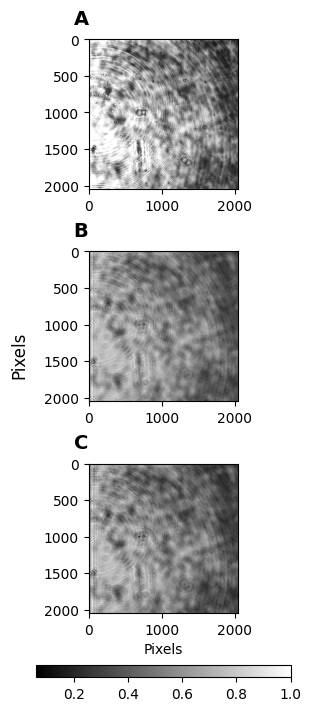

In [56]:
fig, ax = plt.subplots(3, 1, figsize=(3,7), layout='constrained')
cmap = 'gray'
h_b, w_b = [(0, 2048),(0,2048)]

holo = imread('/content/drive/MyDrive/Kai physics/3rd year/Lab B/Holography/images/day3/soap/100.bmp')
HandlerPathCollection = im_orig[:2048,:2048] / 256
im_base = imread('/content/drive/MyDrive/Kai physics/3rd year/Lab B/Holography/images/day3/soap/base.bmp')
im_base = im_bg[:2048,:2048] / 256

# holo = (im_orig/im_bg) # substruct background and normalize pixels
# holo = holo / holo.max()
# height, width = np.shape(holo)
# holo = holo[:2048,:2048] # crop to shape power of 2 for faster proccessing

ax[0].imshow(holo[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap=cmap, label='hologram')
ax[0].set_label('hologram')

recon_121 = angular_spectrum_reconstruct(121, holo, wave_length, M, f,pixel_size)
recon_131 = angular_spectrum_reconstruct(131, holo, wave_length, M, f,pixel_size)
abs_121 = np.absolute(recon_121)
abs_121 = abs_121 / abs_121.max()
abs_131 = np.absolute(recon_131)
abs_131 = abs_131 / abs_131.max()

ax[1].imshow(abs_121[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap=cmap, label='z=121 [\mu m]')
ax[1].set_label('z=121 [\mu m]')

im = ax[2].imshow(abs_131[h_b[0]:h_b[1], w_b[0]:w_b[1]], cmap=cmap, label='z=131[\mu m]')
ax[2].set_label('z=121 [\mu m]')

for n, axes in enumerate(ax):
    axes.text(-0.1, 1.1, string.ascii_uppercase[n], transform=axes.transAxes, size=14, weight='bold')

# fig.supxlabel('Pixels')
ax[2].set_xlabel('Pixels')
fig.supylabel('Pixels')
fig.colorbar(im, location='bottom', orientation='horizontal')